In [1]:
!pip install transformers datasets torch

from datasets import load_dataset,Dataset
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
import re


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
# Load the Quora Question Answer dataset
dataset = load_dataset('toughdata/quora-question-answer-dataset')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [3]:
# Initialize tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [4]:
# Add a padding token
tokenizer.pad_token = tokenizer.eos_token

In [7]:
# Normalize punctuation function
def normalize_punctuation(text):
    text = re.sub(r'[^\w\s\.?!"]', '', text)
    text = re.sub(r'\s([?.!;:])', r'\1', text)
    text = re.sub(r'([?.!;:])', r' \1 ', text)
    text = re.sub(r'“|”', '"', text)
    text = re.sub(r'‘|’', "'", text)
    text = re.sub(r'–', '-', text)
    text = re.sub(r'—', '-', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [5]:
# Preprocess function
def preprocess_function(examples):
    questions = [normalize_punctuation(q) for q in examples['question']]
    answers = [normalize_punctuation(a) for a in examples['answer']]
    inputs = [f"Question: {q} Context: {a}" for q, a in zip(questions, answers)]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding='max_length', return_tensors='pt')
    labels = tokenizer(answers, max_length=512, truncation=True, padding='max_length', return_tensors='pt')

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [8]:
# Tokenize dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/56402 [00:00<?, ? examples/s]

In [9]:
# Split dataset into training and evaluation sets
split_dataset = tokenized_datasets['train'].train_test_split(test_size=0.1)
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

In [10]:

# Convert processed data to Dataset object
def create_dataset(tokenized_data):
    return Dataset.from_dict({
        'input_ids': tokenized_data['input_ids'],
        'attention_mask': tokenized_data['attention_mask'],
        'labels': tokenized_data['labels']
    })


In [11]:
train_dataset = create_dataset(train_dataset)
eval_dataset = create_dataset(eval_dataset)


In [12]:
# Define the device (CPU)
device = torch.device('cpu')

In [13]:
# Load pre-trained GPT model
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [14]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=1000,
    save_total_limit=2,
    remove_unused_columns=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

In [16]:
# Fine-tune the model
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,2.234300,2.041908


TrainOutput(global_step=12691, training_loss=2.1014036482910243, metrics={'train_runtime': 8251.9581, 'train_samples_per_second': 6.151, 'train_steps_per_second': 1.538, 'total_flos': 1.3263444836352e+16, 'train_loss': 2.1014036482910243, 'epoch': 1.0})

In [17]:
# Evaluate the model
results = trainer.evaluate()
print(results)


{'eval_loss': 2.0419082641601562, 'eval_runtime': 254.664, 'eval_samples_per_second': 22.151, 'eval_steps_per_second': 5.541, 'epoch': 1.0}


In [18]:
# Save the model and tokenizer
model.save_pretrained('./fine_tuned_gpt2_model')
tokenizer.save_pretrained('./fine_tuned_gpt2_model')

('./fine_tuned_gpt2_model/tokenizer_config.json',
 './fine_tuned_gpt2_model/special_tokens_map.json',
 './fine_tuned_gpt2_model/vocab.json',
 './fine_tuned_gpt2_model/merges.txt',
 './fine_tuned_gpt2_model/added_tokens.json')

In [19]:
# Load the fine-tuned model and tokenizer
model = GPT2LMHeadModel.from_pretrained('./fine_tuned_gpt2_model').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('./fine_tuned_gpt2_model')


In [23]:
def get_answer(question, context):
    input_text = f"question: {question} context: {context}"
    inputs = tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True).to(device)
    outputs = model.generate(inputs['input_ids'], max_length=512, num_beams=5, early_stopping=True)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return answer

In [24]:
# Get a subset of the dataset
subset_size = 10
questions_subset = dataset['train']['question'][:subset_size]
contexts_subset = dataset['train']['answer'][:subset_size]


In [25]:

# Generate and print answers for the subset
for question, context in zip(questions_subset, contexts_subset):
    answer = get_answer(question, context)
    print("Question:", question)
    print("Answer:", answer)
    print("\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Why whenever I get in the shower my girlfriend want to join?
Answer: question: Why whenever I get in the shower my girlfriend want to join? context: Isn’t it awful? You would swear that there wasn’t enough hot water to go around!





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: What is a proxy, and how can I use one?
Answer: question: What is a proxy, and how can I use one? context: A proxy server is a system or router that provides a gateway between users and the internet. Therefore, it helps prevent cyber attackers from entering a private network. It is a server, referred to as an “intermediary” because it goes between end-users and the web pages they visit online.
 When a computer connects to the internet, it uses an IP address. This is similar to your home’s street address, telling incoming data where to go and marking outgoing data with a return address for other devices to authenticate. A proxy server is essentially a computer on the internet that has an IP address of its own.
 How a Proxy Works
Because a proxy server has its own IP address, it acts as a go-between for a computer and the internet. Your computer knows this address, and when you send a request on the internet, it is routed to the proxy, which then gets the response from the web 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: What song has the lyrics "someone left the cake out in the rain"?
Answer: question: What song has the lyrics "someone left the cake out in the rain"? context: MacArthur's Park





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: I am the owner of an adult website called https://matureanallovers.com. Can anyone offer any SEO tips to help improve my SERP ranking on Google?
Answer: question: I am the owner of an adult website called https://matureanallovers.com. Can anyone offer any SEO tips to help improve my SERP ranking on Google? context: Don't let apps that are liers put adds on your site. Like ones that say they have free age verification, but try charging your card. There all fucking liers, just dont understand why sites promote them and let them post there lies on your site. Also if you want your site to be better, when I click on mature anal lover's. It does not go to that it goes to a lying BS hook up site, that charges you for age verification. Like mature women just a bummer I can't get to the site. Big waist of my time really. Sure your making money from the bastards, if not making money from them. Your getting screwed then.





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Does the Bible mention anything about a place "between" heaven and hell?
Answer: question: Does the Bible mention anything about a place "between" heaven and hell? context: St. John in the book of Revelation mentions an address that some scholars suggest might refer the the place that has become known as ‘purgatory.’ Somewhere close to 1600 Pennsylvania Av.





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: What are useful free and open-source tools for devops and sysadmin folks?
Answer: question: What are useful free and open-source tools for devops and sysadmin folks? context: Can't live without screen, vim, git, puppet, fabric and zabbix...





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: The justice department has told the state of Missouri that they can’t void federal gun laws. What would the justice department seek to do if the state went ahead with their plans anyways? Have many states pushed back against the federal government?
Answer: question: The justice department has told the state of Missouri that they can’t void federal gun laws. What would the justice department seek to do if the state went ahead with their plans anyways? Have many states pushed back against the federal government? context: 🤣🤣🤣 its not much different than states legalizing Marijuana for their residents..whats good for the goose..is good for the gander 😉😉





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: Why are the Kardashians so popular? Why are people obsessed with the Kardashians?
Answer: question: Why are the Kardashians so popular? Why are people obsessed with the Kardashians? context: Answer is simple - They are rich and beautiful!
 Their net worths are last reported were:
 Kim Kardashian – $85 million
 Kourtney Kardashian – $20 million
 Khloe Kardashian – $20 million
 Kendall Jenner – $12 million
 Kylie Jenner – $10 million
 No surprise people want to know how they make these money and how they SPEND it xx





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: How fast could the US Air Force SR-71 Blackbird fly if it pushed its engines to the point of destruction as some MiG-25 Foxbats did chasing the Blackbird?
Answer: question: How fast could the US Air Force SR-71 Blackbird fly if it pushed its engines to the point of destruction as some MiG-25 Foxbats did chasing the Blackbird? context: These questions are always tilted by purpose and timing.. The Foxbat could fly higher than any modern Fighter today, and I do believe the last one was retired in 2020.. It could go at Mach 3 and it had missiles.. I do believe it got to 120,000 feet in testing, that is essentially Outer Space.. You also need to remember it was a large plane with big engines.. The Blackbird just took photos, the Foxbat was a Fighter Jet



Question: Did a landlord ever offer to lower your rent so that you wouldn't leave?
Answer: question: Did a landlord ever offer to lower your rent so that you wouldn't leave? context: it’s never happened that a landlord has offer

**Distribution Plot**

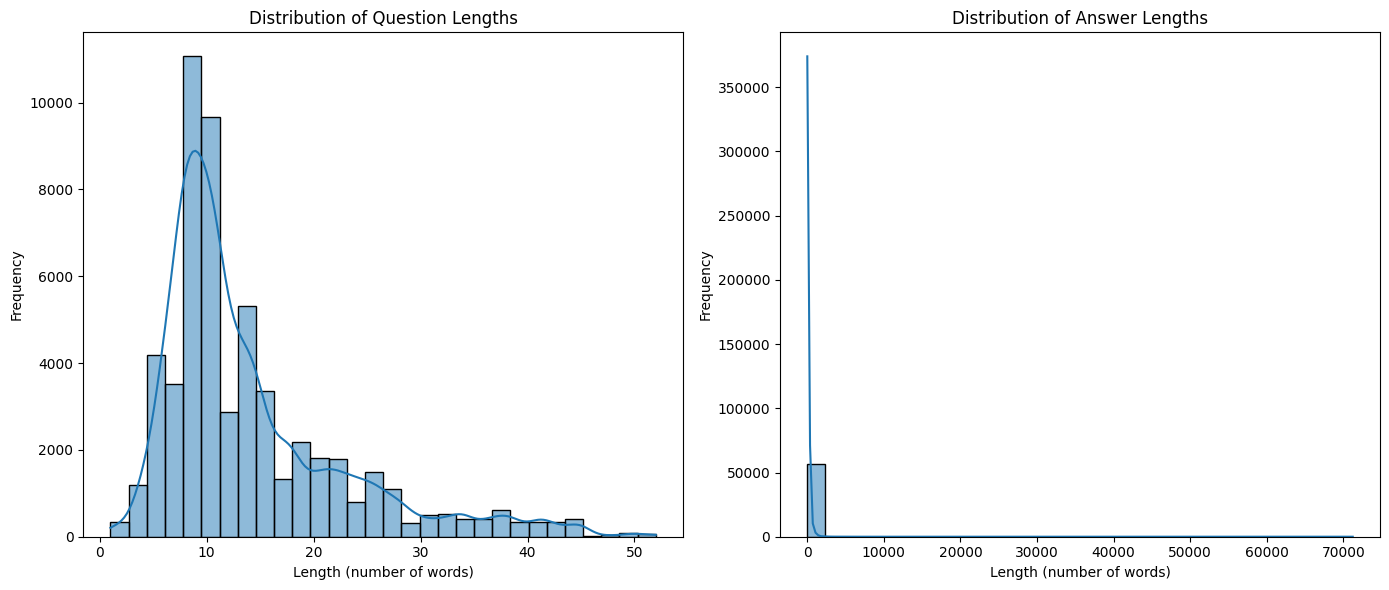

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load dataset
from datasets import load_dataset
dataset = load_dataset('toughdata/quora-question-answer-dataset')

# Convert to pandas DataFrame for easier handling
df = pd.DataFrame(dataset['train'])

# Calculate lengths of questions and answers
df['question_length'] = df['question'].apply(lambda x: len(x.split()))
df['answer_length'] = df['answer'].apply(lambda x: len(x.split()))

# Plot distribution of question and answer lengths
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['question_length'], kde=True, bins=30)
plt.title('Distribution of Question Lengths')
plt.xlabel('Length (number of words)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['answer_length'], kde=True, bins=30)
plt.title('Distribution of Answer Lengths')
plt.xlabel('Length (number of words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**Feature Importance**

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


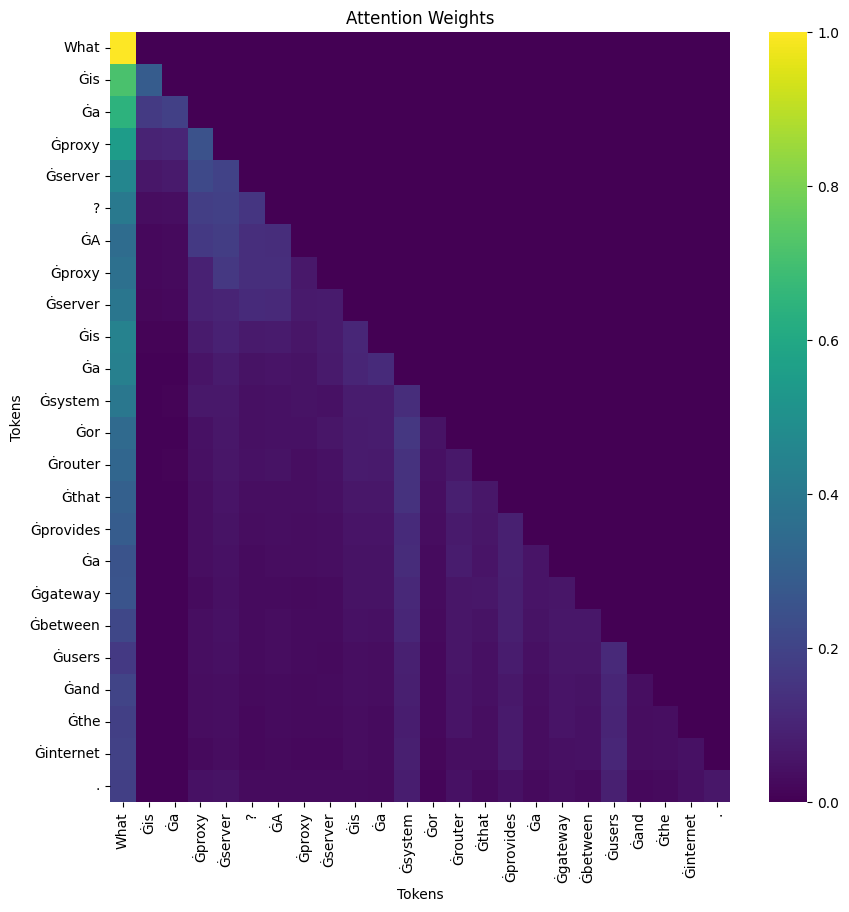

In [27]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the fine-tuned model and tokenizer
model = GPT2Model.from_pretrained('./fine_tuned_gpt2_model', output_attentions=True)
tokenizer = GPT2Tokenizer.from_pretrained('./fine_tuned_gpt2_model')

def get_attention_weights(input_text):
    inputs = tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)

    # Extract attention weights from the outputs
    attentions = outputs.attentions
    return attentions

def visualize_attention(attentions, tokens):
    attention = attentions[-1][0]  # Use the last layer's attention
    attention = attention.mean(dim=0).squeeze().cpu().detach().numpy()  # Average attention heads

    # Plot heatmap of attention weights
    plt.figure(figsize=(10, 10))
    sns.heatmap(attention[:len(tokens), :len(tokens)], xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title('Attention Weights')
    plt.xlabel('Tokens')
    plt.ylabel('Tokens')
    plt.show()

# Example usage
question = "What is a proxy server?"
context = "A proxy server is a system or router that provides a gateway between users and the internet."
input_text = f"{question} {context}"

# Get attention weights
attentions = get_attention_weights(input_text)

# Tokenize input
input_ids = tokenizer.encode(input_text, return_tensors='pt')[0]
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Visualize attention weights
visualize_attention(attentions, tokens)


In [30]:
logs = trainer.state.log_history

**Model Performance**

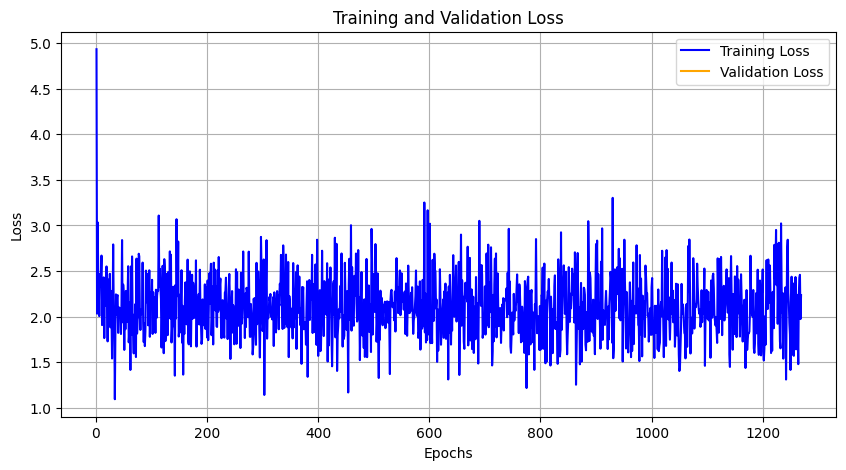

In [31]:
# Extract training and evaluation loss from logs
train_loss = [log['loss'] for log in logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]

# Create epoch range based on the length of the training loss
epochs_train = range(1, len(train_loss) + 1)
epochs_eval = range(1, len(eval_loss) + 1)

# Plot training and evaluation loss
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(epochs_train, train_loss, label='Training Loss', color='blue')

# Plot evaluation loss only if it's available
if eval_loss:
    plt.plot(epochs_eval, eval_loss, label='Validation Loss', color='orange')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()
